In [41]:
#libraries
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
#reading the data
netflix = pd.read_csv('netflix_titles.csv')
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
#showing the dataset infos
netflix.info()
#showing how many missing values per column
netflix.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [5]:
#since director, cast and country columns have so many missing values, I'll drop them (won't use them on the clustering anyway)
#also show_id, date_added, release_year and description because I won't use them too
cols_to_drop = ['director', 'cast', 'country', 'date_added', 'release_year', 'description']
netflix.drop(cols_to_drop, axis = 1, inplace = True)

In [6]:
netflix.drop('show_id', axis = 1, inplace = True)

In [7]:
#filling the missing values on 'rating' column with most frequent values (using imputation)
imputer = SimpleImputer(strategy = 'most_frequent')
netflix['rating'] = imputer.fit_transform(netflix[['rating']]).ravel()

In [8]:
#quick dataset visualisation and infos after the previous operations
netflix.head()

,type,title,rating,duration,listed_in
0,Movie,Dick Johnson Is Dead,PG-13,90 min,Documentaries
1,TV Show,Blood & Water,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries"
2,TV Show,Ganglands,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
3,TV Show,Jailbirds New Orleans,TV-MA,1 Season,"Docuseries, Reality TV"
4,TV Show,Kota Factory,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ..."


In [9]:
#Separating the column duration into two columns: one for minutes and one for seasons since Tv shows and Movies don't have the same duration unit.
netflix['duration_seasons'] = netflix.apply(lambda x: int(x['duration'].split(" ")[0]) if pd.notna(x['duration']) 
                                        and "Season" in x['duration'] else "", axis=1)
netflix['duration_minutes'] = netflix.apply(lambda x: int(x['duration'].split(" ")[0]) if pd.notna(x['duration']) 
                                            and "min" in x['duration'] else "", axis=1)

In [10]:
#dropping duration column
netflix.drop('duration', axis = 1, inplace = True)

In [11]:
netflix.head()

,type,title,rating,listed_in,duration_seasons,duration_minutes
0,Movie,Dick Johnson Is Dead,PG-13,Documentaries,,90
1,TV Show,Blood & Water,TV-MA,"International TV Shows, TV Dramas, TV Mysteries",2,
2,TV Show,Ganglands,TV-MA,"Crime TV Shows, International TV Shows, TV Act...",1,
3,TV Show,Jailbirds New Orleans,TV-MA,"Docuseries, Reality TV",1,
4,TV Show,Kota Factory,TV-MA,"International TV Shows, Romantic TV Shows, TV ...",2,


In [12]:
#checking for null values
netflix.isnull().sum()

type                0
title               0
rating              0
listed_in           0
duration_seasons    0
duration_minutes    0
dtype: int64

In [13]:
#checking for duplicates
netflix.duplicated().sum()

0

In [14]:
#How many unique values inside the column 'rating'
netflix['rating'].nunique()

17

In [15]:
#applying ordinal encoding to the 'rating' column
oe = OrdinalEncoder()
netflix['rating'] = oe.fit_transform(netflix[['rating']])

In [16]:
#dataset after the ordinal encoding
netflix.head()

,type,title,rating,listed_in,duration_seasons,duration_minutes
0,Movie,Dick Johnson Is Dead,7.0,Documentaries,,90
1,TV Show,Blood & Water,11.0,"International TV Shows, TV Dramas, TV Mysteries",2,
2,TV Show,Ganglands,11.0,"Crime TV Shows, International TV Shows, TV Act...",1,
3,TV Show,Jailbirds New Orleans,11.0,"Docuseries, Reality TV",1,
4,TV Show,Kota Factory,11.0,"International TV Shows, Romantic TV Shows, TV ...",2,


In [17]:
#creating a function to split the values in the column 'listed_in'
def split_del(genres):
    result = [] 
    for i in genres:
        delimiters = ",", "&"
        regex_pattern = '|'.join(map(re.escape, delimiters))
        result.extend(re.split(regex_pattern, i))
        result = [i.strip() if i not in ['', 'missing'] else i for i in result]
    return result

In [18]:
#now we call the function and apply one hot encoding
unique_genres = set(split_del(netflix['listed_in']))
for genre in unique_genres:
    netflix[genre] = netflix['listed_in'].apply(lambda x : int(genre in x)) 

In [19]:
#checking the dataset
netflix.head()

,type,title,rating,listed_in,duration_seasons,duration_minutes,Kids' TV,Romantic TV Shows,Dramas,TV Dramas,...,Anime Features,Classic Movies,Adventure,Sci-Fi,Independent Movies,British TV Shows,Anime Series,TV Action,TV Horror,Musicals
0,Movie,Dick Johnson Is Dead,7.0,Documentaries,,90,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TV Show,Blood & Water,11.0,"International TV Shows, TV Dramas, TV Mysteries",2,,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,TV Show,Ganglands,11.0,"Crime TV Shows, International TV Shows, TV Act...",1,,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,TV Show,Jailbirds New Orleans,11.0,"Docuseries, Reality TV",1,,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TV Show,Kota Factory,11.0,"International TV Shows, Romantic TV Shows, TV ...",2,,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#filling the empty values in duration columns and dropping 'listed_in'
netflix['duration_seasons'].replace("", 0, inplace = True)
netflix['duration_minutes'].replace("", 0, inplace = True)
netflix.drop('listed_in', axis = 1, inplace = True)

In [23]:
#encoding the column 'type'
le = LabelEncoder()
netflix['type'] = le.fit_transform(netflix['type'])

In [24]:
netflix.head()

,type,title,rating,duration_seasons,duration_minutes,Kids' TV,Romantic TV Shows,Dramas,TV Dramas,Action,...,Anime Features,Classic Movies,Adventure,Sci-Fi,Independent Movies,British TV Shows,Anime Series,TV Action,TV Horror,Musicals
0,0,Dick Johnson Is Dead,7.0,0,90,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Blood & Water,11.0,2,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Ganglands,11.0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
3,1,Jailbirds New Orleans,11.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Kota Factory,11.0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#Now that our dataset become clean, now we select the feature for the K-means algo
X = netflix.drop('title', axis = 1)

In [29]:
#then applying the scaler since the K-means algo will expect scaled values
ss = StandardScaler()
X_ss = ss.fit_transform(X)

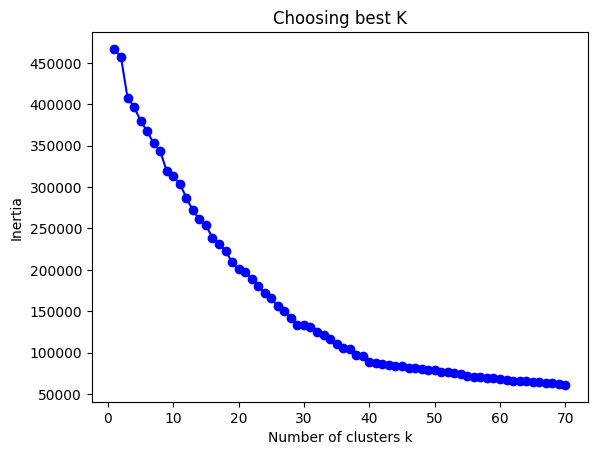

In [36]:
#then we choose the best K by using the elbow method (and using a range of 70)
ks = []
for k in range(1, 71):
    kmeans = KMeans(n_clusters = k, random_state = 48)
    kmeans.fit(X_ss)
    ks.append(kmeans.inertia_)
plt.plot(range(1,71), ks, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Choosing best K')
plt.show()

In [37]:
#As you can see in the visualization above, the elbow point is almost at k=30, so I'll be using it
kmeans = KMeans(n_clusters = 30, random_state = 42)
clusters = kmeans.fit_predict(X_ss)
netflix['cluster'] = clusters

In [39]:
netflix[['title', 'type', 'cluster']].head()

,title,type,cluster
0,Dick Johnson Is Dead,0,23
1,Blood & Water,1,24
2,Ganglands,1,27
3,Jailbirds New Orleans,1,19
4,Kota Factory,1,29


In [40]:
#now let's check how many shows are in each cluster
netflix['cluster'].value_counts()

cluster
8     1200
1      902
23     664
3      659
6      607
12     560
5      381
9      362
15     361
17     336
25     318
28     265
21     241
4      231
19     228
10     224
0      162
26     151
14     116
27     111
29     109
20     101
7       92
13      77
24      76
2       67
11      65
16      57
18      56
22      28
Name: count, dtype: int64

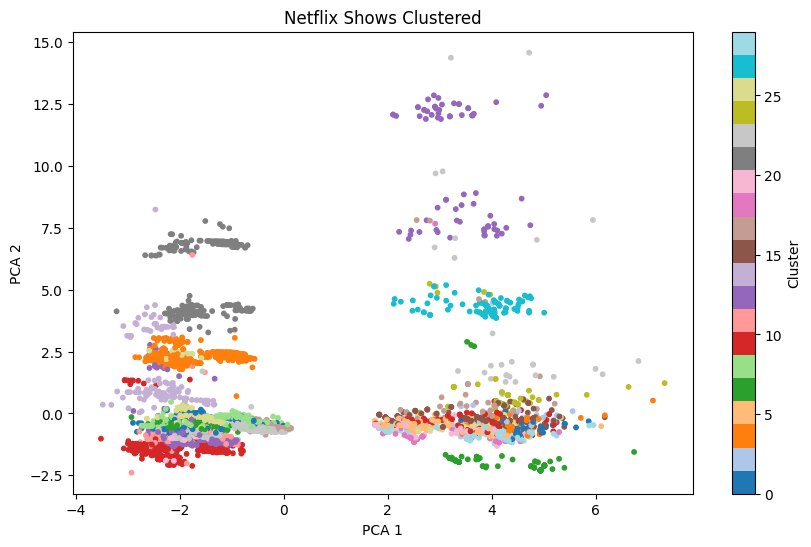

In [42]:
#Now let's visualize the results (used PCA to keep a 2d plot)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_ss)
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab20', s=10)
plt.title("Netflix Shows Clustered")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()